In [2]:
! module restore

Restoring modules from user's default, for system: "infer-skylake"


In [3]:
! source activate dialogpt

In [5]:
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.11.0-cp38-cp38-manylinux1_x86_64.whl (750.6 MB)
     |████████████████████████████████| 21.0 MB 7.3 MB/s eta 0:00:01
  Using cached pycrypto-2.6.1.tar.gz (446 kB)
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp38-cp38-linux_x86_64.whl size=495538 sha256=696c126c76c041bc83ddc720e51a92891c8801cb38d85e2038a26617abdcfec5
  Stored in directory: /home/alanwang/.cache/pip/wheels/d0/99/d0/0298ea019d63f1d63a0965b9944b719e875f9bd6ffc6dcf293
Successfully built pycrypto


In [7]:
! pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.8 MB 6.0 MB/s eta 0:00:01
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
     |████████████████████████████████| 156 kB 130.1 MB/s eta 0:00:01
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached importlib_metadata-4.11.3-py3-none-any.whl (18 kB)
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.5.1 requires absl-py~=0.10, but you'll have absl-py 1.0.0 which is incompatible.


In [8]:
#hide
# Imports


"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [9]:
#collapse
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [10]:
! gdown https://drive.google.com/uc?id=1Lp-diuMohUTGyB9BSTFgeGZyY3dkNuEg

Downloading...
From: https://drive.google.com/uc?id=1Lp-diuMohUTGyB9BSTFgeGZyY3dkNuEg
To: /home/alanwang/DialoGPT/final_es_conv.csv
100%|██████████████████████████████████████| 20.3M/20.3M [00:00<00:00, 91.3MB/s]


In [11]:
df = pd.read_csv('final_es_conv.csv')
df = df.dropna()
trn_df, val_df = train_test_split(df, test_size = 0.2)
trn_df.head()

,response,context,context/0,context/1,context/2,context/3,context/4,context/5,context/6,context/7,context/8,context/9
17253,¡Tuvo ayuda!,"Bueno, déjeme decirle algo, no lo hizo usted s...",El gran Sir Wilfrid Robarts lo hizo de nuevo.,Qué mujer tan malvada soy y que brillantemente...,como la gente de ahí fuera.,"Me detesta, ¿verdad?","Sí llevase yo la acusación, lo sería.","No será cadena perpetua, ¿verdad?",Con toda seguridad será acusada de perjurio ju...,Ya ha oído al Juez.,¿Voy a ir a prisión?,¿Prisión?
2452,Se la llevó Mark Alexandrovich.,¿Nadie ha visto dónde está mi ardilla?,"Ahora te acostaré, te desvestiré.","Ven a mí, pequeño mío, Boria...",Démelo.,No grites.,"Para remate, tengo que sostenerlo.","Irina, sosténlo por un momento.",Hay que encontrar algún juguete.,Se me van a reventar los tímpanos de los oídos.,Tranquilícenlo.,Agárrala.
15808,Déjame en mi casa.,¡Creo que ahora están furiosos!,"¡Ay, carajo, ahí vienen!","¡Hago lo que puedo, viejo!",¡Pierde a esos idiotas!,"¡Ay, caray!","¡Vamos, apúrate!",Ven.,Participo.,"¿Participas o no, entonces?",Sí.,¿Eres de primer año?
1101,"En Io que a nosotros se refiere, es Io único q...",""" Un hombre muy querido siempre entiende mis p...","capítulo 10, versículo 11.",A veces leo sobre eI amor en eI libro de daniel.,Pero deberé cambiar el texto del sermón.,No estoy de acuerdo.,Nos ha dejado en ridículo.,Sobre todo HiIdegarde.,Toda Ia ciudad sentirá una conmoción.,Usaba el nombre del juez que Ie condenó tras p...,EI hombre que estranguló a su esposa.,"Sí, John Louton."
39464,"¿Vienes con nosotros, viejo?",¡Bebamos un poco de sake!,Me alcanzarán para cruzar el Styx.,Los 5 son mi parte.,Gané 105 centavos.,¡Maldición!,Perdiste otra vez.,"Naciste malandrín, eso es todo.",Me avergüenzo de mí mismo.,"Debes tener mas cuidado, Samurai.",Aunque la piedad de Buddha cuesta dinero.,Mejor olvídalo.


In [12]:
len(trn_df), len(val_df)

(40374, 10094)

In [13]:
#hide
from collections import Counter
from statistics import mean, median, stdev
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#collapse
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [15]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

In [16]:
#collapse
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

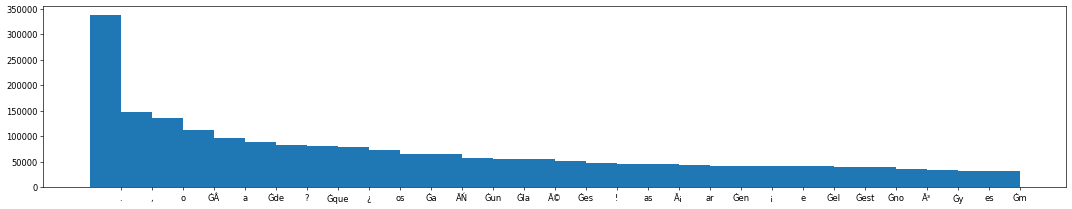

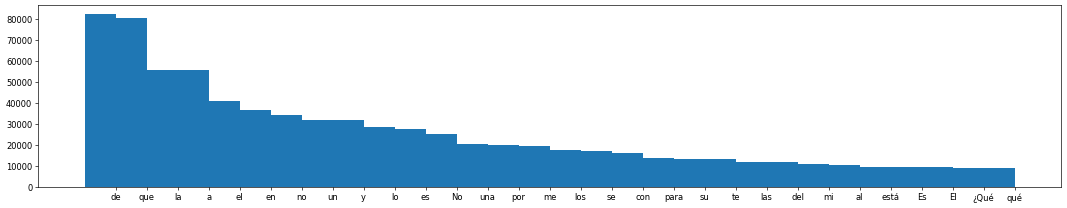

In [17]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [18]:
#collapse
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 150.07675731906673, Median: 141.0, Standard Deviation: 44.85533047432236, 90th Percentile: 513.0


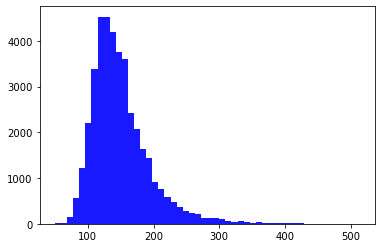

In [19]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)

In [20]:
#collapse
def construct_conv(row, tokenizer, eos = True):
    # from: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.max_len - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                if len(conv) > block_size: continue
                self.examples.append(conv)

            # Note that we are loosing the last truncated example here for the sake of simplicity (no padding)
            # If your dataset is small, first you should loook for a bigger one :-) and second you
            # can change this behavior by adding (model specific) padding.

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [21]:
#hide
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

# Training and Evaluating

In [22]:
#collapse
# Training of model

def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result


In [23]:
#collapse
# Main show runner

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [25]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16419), started 0:00:22 ago. (Use '!kill 16419' to kill it.)

In [26]:
main(trn_df, val_df)

04/30/2022 23:42:49 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
04/30/2022 23:42:49 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/microsoft/DialoGPT-small/config.json from cache at cached/c3a09526c725b854c685b72cf60c50f1fea9b0e4d6227fa41573425ef4bd4bc6.36332ed8c811a8f0488055ce93ce78909e2f8e027955fba2faa82bfc6728105b
04/30/2022 23:42:49 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,


04/30/2022 23:42:59 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/microsoft/DialoGPT-small/pytorch_model.bin in cache at cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8c26470f335b7c0e46a21483
04/30/2022 23:42:59 - INFO - transformers.file_utils -   creating metadata file for cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8c26470f335b7c0e46a21483
04/30/2022 23:42:59 - INFO - filelock -   Lock 46915058115872 released on cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8c26470f335b7c0e46a21483.lock
04/30/2022 23:42:59 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/microsoft/DialoGPT-small/pytorch_model.bin from cache at cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.